This particular challenge is perfect for data scientists looking to get started with Natural Language Processing. You are predicting whether a given tweet is about a real disaster or not. If so, predict a 1. If not, predict a 0.

# Data overview

* `id` - a unique identifier for each tweet
* `text` - the text of the tweet
* `location` - the location the tweet was sent from (may be blank)
* `keyword` - a particular keyword from the tweet (may be blank)
* `target` - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

In [1]:
# Import all the tools
import warnings
from tqdm import tqdm_notebook
import seaborn as sns
from plotly.offline import init_notebook_mode
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import nltk
from sklearn.experimental import enable_iterative_imputer
from tqdm.notebook import tqdm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier, BaggingClassifier, RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score
# from sklearn.impute import IterativeImputer
warnings.filterwarnings("ignore")

import os
cwd = os.getcwd()
cwd = cwd.replace('\\','/')

train = pd.read_csv(cwd + "/nlp/train.csv")
test = pd.read_csv(cwd + "/nlp/test.csv")
sub = pd.read_csv(cwd + "/nlp/sample_submission.csv")


# plots inside the notebook
%matplotlib inline
print('Train Shape: {}\nMissing Data: {}\nDuplicates: {}\n'.format(
    train.shape, train.isna().sum().sum(), train.duplicated().sum()))
print('Test Shape: {}\nMissing Data: {}\nDuplicates: {}\n'.format(
    test.shape, test.isna().sum().sum(), test.duplicated().sum()))
# remove duplicates from train
train_d = train.drop_duplicates()

if train.shape == train_d.shape:
    print('No duplicates')
else:
    print('Dropping Duplicates\nNew Train Shape: {}'.format(train_d.shape))
    
df_data = pd.concat([train_d, test])

Train Shape: (7613, 5)
Missing Data: 2594
Duplicates: 0

Test Shape: (3263, 4)
Missing Data: 1131
Duplicates: 0

No duplicates


In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int8','int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2

    for col in df.columns:
        col_type = df[col].dtypes

        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()

            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2

    if verbose:
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
 
    return df

In [3]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


# Exploratory Data Analysis (EDA)

In [5]:
train.dtypes

id           int64
keyword     object
location    object
text        object
target       int64
dtype: object

In [6]:
train.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [7]:
train['location'].value_counts()

USA                    104
New York                71
United States           50
London                  45
Canada                  29
                      ... 
MontrÌ©al, QuÌ©bec       1
Montreal                 1
ÌÏT: 6.4682,3.18287      1
Live4Heed??              1
Lincoln                  1
Name: location, Length: 3341, dtype: int64

In [8]:
train['location'].value_counts()

USA                    104
New York                71
United States           50
London                  45
Canada                  29
                      ... 
MontrÌ©al, QuÌ©bec       1
Montreal                 1
ÌÏT: 6.4682,3.18287      1
Live4Heed??              1
Lincoln                  1
Name: location, Length: 3341, dtype: int64

In [9]:
train['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

or

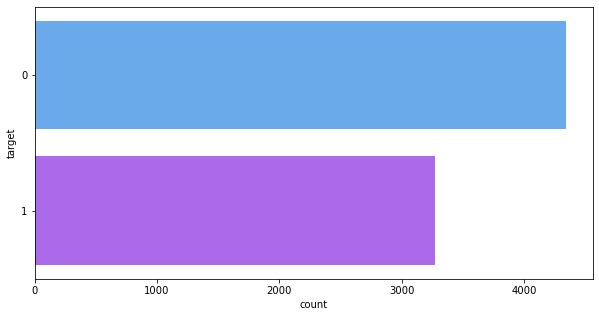

In [10]:
plt.figure(figsize=(10,5))
sns.countplot(y=train['target'], palette='cool', orient='h')
plt.show()

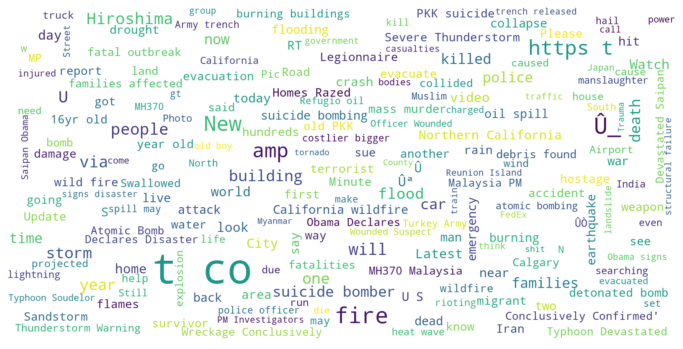

In [11]:
#Disaster Tweets wordcloud 
disaster_tweets = train[train.target == 1]
disaster_string = []
for t in disaster_tweets.text:
    disaster_string.append(t)
disaster_string = pd.Series(disaster_string).str.cat(sep=' ')
wordcloud = WordCloud(width=1600, height=800,max_font_size=100, background_color='white').generate(disaster_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Feature Engineering (FE)

## Feature generation

In [12]:
import string
import nltk
nltk.download('stopwords')
stopword = nltk.corpus.stopwords.words('english')

def specs(df_data):
    # lenth of № of characters
    df_data['body_len'] = df_data['text'].apply(lambda x: len(x) - x.count(" ")) # x.count(" ") - number of spaces; len(x) - each character

    # % pucntuation
    def count_punct(text):
        count = sum([1 for char in text if char in string.punctuation]) # 1 if comma, etc
        return round(count/(len(text) - text.count(" ")), 3)*100
    df_data['punct%'] = df_data['text'].apply(lambda x: count_punct(x))

    # word_count
    df_data['word_count'] = df_data['text'].apply(lambda x: len(str(x).split())) # split - divides on words
    # unique_word_count
    df_data['unique_word_count'] = df_data['text'].apply(lambda x: len(set(str(x).split()))) # unique - use set
    # stop_word_count
    df_data['stop_word_count'] = df_data['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in stopword]))
    # url_count
    df_data['url_count'] = df_data['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
    # mean_word_length
    df_data['mean_word_length'] = df_data['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
    # char_count
    df_data['char_count'] = df_data['text'].apply(lambda x: len(str(x)))
    return df_data

# df_data = specs(df_data)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\misha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
# METAFEATURES = ['word_count', 'unique_word_count', 'stop_word_count', 'url_count', 'mean_word_length',
#                 'char_count']
# DISASTER_TWEETS = train['target'] == 1

# fig, axes = plt.subplots(ncols=2, nrows=len(METAFEATURES), figsize=(20, 50), dpi=100)

# for i, feature in enumerate(METAFEATURES):
#     sns.distplot(train.loc[~DISASTER_TWEETS][feature], label='Not Disaster', ax=axes[i][0], color='green')
#     sns.distplot(train.loc[DISASTER_TWEETS][feature], label='Disaster', ax=axes[i][0], color='red')

#     sns.distplot(train[feature], label='Training', ax=axes[i][1])
#     sns.distplot(test[feature], label='Test', ax=axes[i][1])
    
#     for j in range(2):
#         axes[i][j].set_xlabel('')
#         axes[i][j].tick_params(axis='x', labelsize=12)
#         axes[i][j].tick_params(axis='y', labelsize=12)
#         axes[i][j].legend()
    
#     axes[i][0].set_title(f'{feature} Target Distribution in Training Set', fontsize=13)
#     axes[i][1].set_title(f'{feature} Training & Test Set Distribution', fontsize=13)

# plt.show()

## Punctuation removing, tokenization, stop-words removing, lemmatization

In [14]:
df_data.head(1)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1.0


In [15]:
import string
import re

# Punctuation
def remove_punct(text):
    text_punct = "".join([char for char in text if char not in string.punctuation])
    return text_punct

# tokenization
def tokenize(text):
    tokens = re.split(
        '\W+', text
    )  # W+ mean that either a word character (A-Za-9) or a dash(-) can go there
    return tokens

# stopwords removing
def remove_stodwords(tokenized_list):
    text = [word for word in tokenized_list if word not in stopword]
    return text

# string.punctuation
df_data['text_punct'] = df_data['text'].apply(lambda x: remove_punct(x))
df_data['text_tokens'] = df_data['text_punct'].apply(lambda x: tokenize(x.lower()))
df_data['text_stopwords'] = df_data['text_tokens'].apply(lambda x: remove_stodwords(x))

#Lemmatization is more complex but precise. Choose it.
wn = nltk.WordNetLemmatizer()
nltk.download('omw-1.4')
nltk.download('wordnet')
def lemmatizing(text_stopwords):
    text = [wn.lemmatize(word) for word in text_stopwords]
    return text

df_data['text_lemmatizing'] = df_data['text_stopwords'].apply(lambda x:lemmatizing(x))
df_data.head(2)

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\misha\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\misha\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,id,keyword,location,text,target,text_punct,text_tokens,text_stopwords,text_lemmatizing
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1.0,Our Deeds are the Reason of this earthquake Ma...,"[our, deeds, are, the, reason, of, this, earth...","[deeds, reason, earthquake, may, allah, forgiv...","[deed, reason, earthquake, may, allah, forgive..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1.0,Forest fire near La Ronge Sask Canada,"[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]"


## Join tokenized text

In [16]:
df_data.drop('text_punct', axis=1, inplace=True)
df_data.drop('text_tokens', axis=1, inplace=True)
df_data.drop('text_stopwords', axis=1, inplace=True)
df_data.drop('text', axis=1, inplace=True)
df_data.drop('keyword', axis=1, inplace=True)
df_data.drop('location', axis=1, inplace=True)
df_data.drop('id', axis=1, inplace=True)

# join clean tokenized text
def join_fun(text):
    string=" "
    ans=string.join(text)
    return ans

df_data['final_text']=df_data['text_lemmatizing'].apply(lambda x:join_fun(x))
df_data.drop('text_lemmatizing', axis=1, inplace=True)
df_data.head(2)

,target,final_text
0,1.0,deed reason earthquake may allah forgive u
1,1.0,forest fire near la ronge sask canada


## TD-IDF

In [17]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# tfidfvec=TfidfVectorizer()

# vec_train=tfidfvec.fit_transform(df_data["final_text"])
# tdidf = pd.DataFrame(vec_train.toarray())
# df_data.drop('final_text', axis=1, inplace=True)

# from sklearn.preprocessing import LabelEncoder
# qualitative = [col for col in df_data if df_data[col].dtype == 'object']
# for feature in qualitative:
#     df_data[feature] = LabelEncoder().fit_transform(df_data[feature])
    
# df_data = reduce_mem_usage(df_data)

# df_data = df_data.reset_index()
# df_data = pd.concat([df_data, tdidf], axis=1)

# print(df_data.shape)

In [18]:
df_data.head(2)

,target,final_text
0,1.0,deed reason earthquake may allah forgive u
1,1.0,forest fire near la ronge sask canada


## BertTokenizier

In [19]:
df_train = df_data[df_data.target.isnull() == False]
df_test = df_data[df_data.target.isnull() == True]
df_test = df_test.drop(['target'],axis=1)

# df_train.drop('body_len', axis=1, inplace=True)
# df_train.drop('punct%', axis=1, inplace=True)
# df_train.drop('word_count', axis=1, inplace=True)
# df_train.drop('unique_word_count', axis=1, inplace=True)
# df_train.drop('stop_word_count', axis=1, inplace=True)
# df_train.drop('url_count', axis=1, inplace=True)
# df_train.drop('mean_word_length', axis=1, inplace=True)
# df_train.drop('char_count', axis=1, inplace=True)

X = df_train.final_text
y = df_train.target
df_train.tail(2)

,target,final_text
7611,1.0,police investigating ebike collided car little...
7612,1.0,latest home razed northern california wildfire...


In [20]:
x_train, x_val, y_train, y_val = train_test_split(X, y, random_state=42)
print(len(x_train), len(y_train))
print(len(x_val), len(y_val))

5709 5709
1904 1904


In [21]:
from transformers import AutoTokenizer

checkpoint = "vinai/bertweet-base" # A pre-trained language model for English Tweets

tokenizer = AutoTokenizer.from_pretrained(checkpoint, normalization=True)

emoji is not installed, thus not converting emoticons or emojis into text. Please install emoji: pip3 install emoji
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [22]:
x_train_input = dict(tokenizer(x_train.to_list(), padding=True, truncation=True, return_tensors="tf"))
x_val_input = dict(tokenizer(x_val.to_list(), padding=True, truncation=True, return_tensors="tf"))

x_test_input = dict(tokenizer(df_test.final_text.to_list(), padding=True, truncation=True, return_tensors="tf"))

In [23]:
tokenizer.pad_token

'<pad>'

In [24]:
from tensorflow.keras.metrics import Metric
import numpy as np


class F1_metric(Metric):
    def __init__(self, name='f1_score', **kwargs):
        super().__init__(name=name, **kwargs)
        # Initialize our metric by initializing the two metrics it's based on:
        # Precision and Recall
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Update our metric by updating the two metrics it's based on
        self.precision.update_state(y_true, tf.math.argmax(y_pred, axis=0), sample_weight) # Ensure to get preds not logits 
        self.recall.update_state(y_true,tf.math.argmax(y_pred, axis=0), sample_weight)

    def reset_state(self):
        self.precision.reset_state()
        self.recall.reset_state()

    def result(self):
        # To get the F1 result, we compute the harmonic mean of the current
        # precision and recall
        return 2 / ((1 / self.precision.result()) + (1 / self.recall.result())) 

In [25]:
stop

NameError: name 'stop' is not defined

In [ ]:
# # clear gpu memory
# from numba import cuda 
# device = cuda.get_current_device()
# device.reset()

In [26]:
import numpy as np
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from transformers import TFAutoModelForSequenceClassification

batch_size = 128
# batch_size = 16 * strategy.num_replicas_in_sync

num_epochs = 5
num_train_steps = (len(x_train_input['input_ids']) // batch_size) * num_epochs

# Define lr_scheduler
lr_scheduler = PolynomialDecay(
    initial_learning_rate=5e-5,
    end_learning_rate=0.,
    decay_steps=num_train_steps
    )

# Define optimizer with lr_scheduler
opt = Adam(learning_rate=lr_scheduler)
loss = SparseCategoricalCrossentropy(from_logits=True)



model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2, return_dict=False) # TFAutoModel.from_pretrained(checkpoint)
model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])


model.fit(
    x_train_input,
    np.array(y_train), 
    validation_data=(
        x_val_input,
        np.array(y_val),
    ),
    batch_size=batch_size, 
    epochs=num_epochs
)

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5


ResourceExhaustedError:  OOM when allocating tensor with shape[5888,3072] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node tf_roberta_for_sequence_classification/roberta/encoder/layer_._9/intermediate/dense/Tensordot/MatMul (defined at D:\miniconda\lib\site-packages\transformers\models\roberta\modeling_tf_roberta.py:390) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_24453]

Function call stack:
train_function


In [ ]:
# # clear gpu memory
# from numba import cuda 
# device = cuda.get_current_device()
# device.reset()

In [ ]:
ch = model(x_test_input, return_dict=True)

In [ ]:
targets = [np.argmax(x) for x in ch['logits']]
# targets
ids = test.id.to_list()

In [ ]:
submission = pd.DataFrame({'id': ids, 'target': targets})
submission.to_csv('E:/downloads/submission.csv', index=False)

# Modeling

## RNN

In [ ]:
import tensorflow as tf
from tensorflow.keras.metrics import AUC
import time
import logging
import gc

In [ ]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)

encoder.adapt(df_data[df_data.target.isnull() == False]['final_text'])
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

In [ ]:
stop

In [ ]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    plt.show()

In [ ]:
# from keras import backend as K
# def recall_m(y_true, y_pred):
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
#     recall = true_positives / (possible_positives + K.epsilon())
#     return recall

# def precision_m(y_true, y_pred):
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
#     precision = true_positives / (predicted_positives + K.epsilon())
#     return precision

# def f1_m(y_true, y_pred):
#     precision = precision_m(y_true, y_pred)
#     recall = recall_m(y_true, y_pred)
#     return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
def createModel(): 
    model = tf.keras.Sequential([
        encoder,
        tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1)
    ])

    model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=['accuracy'])
    return(model)

1. The `first layer` is the encoder, which converts the text to a sequence of token indices.
2. After the encoder is an embedding layer. An `embedding layer` stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.
3. The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input `forward` and `backwards` through the RNN layer and then concatenates the `final output`.

In [ ]:
X = df_data[df_data.target.isnull() == False]['final_text']
y = df_data[df_data.target.isnull() == False]['target']

df_test = df_data[df_data.target.isnull() == True]['final_text']

In [ ]:
from sklearn.model_selection import KFold
from keras.callbacks import EarlyStopping
kf = KFold(n_splits=2, shuffle=True, random_state=42)

test_preds = []

for fold, (train_idx, test_idx) in enumerate(kf.split(X, y)):
    print(f"****** fold: {fold+1} *******")
    X_train, X_valid = X[train_idx], X[test_idx]
    y_train, y_valid = y[train_idx], y[test_idx]
    
    es = EarlyStopping(monitor='val_accuracy',mode='max', patience=3, verbose=1, restore_best_weights=True)
    
    model = createModel()
    
    history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=50, batch_size = 64, callbacks = [es])
    test_preds.append(model.predict(df_test).squeeze())
    plot_graphs(history, 'accuracy')
    del X_train, X_valid, y_train, y_valid, model, history
    gc.collect() 

In [ ]:
model = createModel()
model.fit(X, y,epochs=7, batch_size = 64)

In [ ]:
np.array([df_test])

In [ ]:
predictions = model.predict(np.array([df_test]))


In [ ]:
sum(test_preds)/kf.n_splits

In [ ]:
sub.head()

In [ ]:
len(test_preds[0])

In [ ]:
sum(test_preds[2]/3263)

In [ ]:
       
def save_submission(y_pred):  
    sub["target"] = y_pred
    assert 2 == sub.shape[1]   
    sub.to_csv("E:/downloads/sample_submission.csv", index=False)
    return sub
save_submission(y_preds).head(3)